In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

print("--- TRACK B: BUILDING THE 'FORECAST CONFIDENCE' CLASSIFIER ---")

# ==============================================================================
# STEP 1: LOAD ALL RAW DATA ASSETS
# ==============================================================================
print("\n--- Step 1: Loading All Raw Data Assets ---")
try:
    champion_model = joblib.load('..\champion_model_phase1.joblib')
    df_analysis = pd.read_csv('..\data\df_analysis.csv')
    df_rh_subdaily = pd.read_csv('..\data\RH_KTM.csv', parse_dates=['Time'], index_col='Time')
    df_wind_subdaily = pd.read_csv('..\data\wind_speed_direction_KTM.csv', parse_dates=['Time'], index_col='Time')
    df_solar_subdaily = pd.read_csv('..\data\globsolar_ktm.csv', parse_dates=['Time'], index_col='Time')
    print("✅ All data assets loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ FATAL ERROR: A required data file was not found. Details: {e}")
    exit()

--- TRACK B: BUILDING THE 'FORECAST CONFIDENCE' CLASSIFIER ---

--- Step 1: Loading All Raw Data Assets ---
✅ All data assets loaded successfully.


In [14]:
# ==============================================================================
# STEP 2: CREATE THE BASE DATAFRAME FOR ANALYSIS (df_recent)
# We start by creating the df_recent_enriched dataframe as it contains all daily aggregated data.
# ==============================================================================
print("\n--- Step 2: Assembling the Base Daily DataFrame for Recent Period ---")
# --- Reconstruct Date Index for df_analysis ---
df_analysis['Date'] = pd.to_datetime(df_analysis['Year'].astype(str) + '-' + df_analysis['Day_of_Year'].astype(str), format='%Y-%j')
df_analysis.set_index('Date', inplace=True)

# --- Process and Aggregate Sub-Daily Data ---
df_rh_subdaily.rename(columns={'Kathmandu Airport': 'RH'}, inplace=True)
df_rh_daily = df_rh_subdaily.resample('D').agg({'RH': ['mean', 'min', 'max']}); df_rh_daily.columns = ['RH_mean', 'RH_min', 'RH_max']

df_wind_subdaily.columns = ['Wind_Dir_deg', 'Wind_Speed_ms']
wind_dir_rad = df_wind_subdaily['Wind_Dir_deg'] * np.pi / 180
df_wind_subdaily['Wind_Dir_x'] = np.cos(wind_dir_rad); df_wind_subdaily['Wind_Dir_y'] = np.sin(wind_dir_rad)
df_wind_daily = df_wind_subdaily.resample('D').agg({'Wind_Speed_ms': ['mean', 'max'], 'Wind_Dir_x': 'mean', 'Wind_Dir_y': 'mean'}); df_wind_daily.columns = ['Wind_Speed_ms_mean', 'Wind_Speed_ms_max', 'Wind_Dir_x_mean', 'Wind_Dir_y_mean']

df_solar_subdaily.rename(columns={'Global Solar Radiation 1 hour average': 'Solar_Rad'}, inplace=True)
df_solar_daily = df_solar_subdaily.resample('D').agg({'Solar_Rad': ['mean', 'max', 'sum']}); df_solar_daily.columns = ['Solar_Rad_mean', 'Solar_Rad_max', 'Solar_Rad_sum']

# --- Join and filter to the recent period ---
df_recent = df_analysis.join(df_rh_daily).join(df_wind_daily).join(df_solar_daily)
df_recent.dropna(subset=['Wind_Speed_ms_mean', 'Solar_Rad_mean'], inplace=True)
df_recent.interpolate(method='time', inplace=True)
print("✅ Base daily dataframe for recent period created.")




--- Step 2: Assembling the Base Daily DataFrame for Recent Period ---
✅ Base daily dataframe for recent period created.


In [15]:
# ==============================================================================
# STEP 3: ENGINEER THE ADVANCED PHYSICS AND INTRA-DAY FEATURES
# ==============================================================================
print("\n--- Step 3: Engineering Advanced Physics and Intra-Day Features ---")
# --- Dew Point ---
a, b = 17.625, 243.04
gamma = (a * df_recent['Min_Temp_C']) / (b + df_recent['Min_Temp_C']) + np.log(df_recent['RH_mean'] / 100.0)
df_recent['Dew_Point_C'] = (b * gamma) / (a - gamma)
print("✅ 'Dew_Point_C' feature created.")

# --- Clear Sky Index ---
max_solar, min_solar = df_recent['Solar_Rad_sum'].max(), df_recent['Solar_Rad_sum'].min()
df_recent['Theoretical_Solar_Rad'] = min_solar + (max_solar - min_solar) * (df_recent['Day_of_Year_sin'] + 1) / 2
df_recent['Clear_Sky_Index'] = df_recent['Solar_Rad_sum'] / (df_recent['Theoretical_Solar_Rad'] + 1e-6)
print("✅ 'Clear_Sky_Index' feature created.")

# --- Intra-Day Solar Dynamics ---
daily_solar_peak_time = df_solar_subdaily.groupby(df_solar_subdaily.index.date)['Solar_Rad'].idxmax().apply(lambda x: x.hour).rename("Solar_Peak_Hour")
morning_solar = df_solar_subdaily[df_solar_subdaily.index.hour.isin(range(6, 12))].resample('D')['Solar_Rad'].sum()
afternoon_solar = df_solar_subdaily[df_solar_subdaily.index.hour.isin(range(12, 18))].resample('D')['Solar_Rad'].sum()
am_pm_solar_ratio = (morning_solar / (afternoon_solar + 1e-6)).rename("AM_PM_Solar_Ratio")
df_recent = df_recent.join(daily_solar_peak_time).join(am_pm_solar_ratio)
print("✅ Intra-day solar dynamic features created.")

# --- Intra-Day Wind Dynamics ---
daily_wind_std = df_wind_subdaily.resample('D')['Wind_Speed_ms'].std().rename("Wind_Speed_Std_Daily")
df_recent = df_recent.join(daily_wind_std)
print("✅ Intra-day wind dynamic features created.")

# ==============================================================================
# STEP 4: CREATE THE TRAINING DATA FOR THE CONFIDENCE MODEL
# ==============================================================================
print("\n--- Step 4: Creating Training Data for the Confidence Model ---")
# --- Generate Champion's errors ---
champion_feature_cols = ['Precipitation_mm', 'Precipitation_7d_rolling_sum', 'Year', 'Month', 'Day_of_Year', 'Day_of_Week', 'Month_sin', 'Month_cos', 'Day_of_Year_sin', 'Day_of_Year_cos', 'Max_Temp_C_lag_1', 'Min_Temp_C_lag_1', 'Max_Temp_C_lag_2', 'Min_Temp_C_lag_2', 'Max_Temp_C_lag_3', 'Min_Temp_C_lag_3', 'Max_Temp_C_lag_7', 'Min_Temp_C_lag_7', 'Precipitation_mm_lag_1', 'Precipitation_mm_lag_2', 'Precipitation_mm_lag_3', 'Precipitation_mm_lag_7', 'Max_Temp_C_rolling_mean_7d', 'Min_Temp_C_rolling_mean_7d', 'Max_Temp_C_rolling_std_7d', 'Min_Temp_C_rolling_std_7d', 'Max_Temp_C_rolling_mean_30d', 'Min_Temp_C_rolling_mean_30d', 'Max_Temp_C_rolling_std_30d', 'Min_Temp_C_rolling_std_30d', 'Precipitation_mm_rolling_sum_7d', 'Precipitation_mm_rolling_std_7d', 'Precipitation_mm_rolling_sum_30d', 'Precipitation_mm_rolling_std_30d', 'Daily_Temp_Range', 'Daily_Temp_Range_lag_1']
df_recent['Daily_Temp_Range'] = df_recent['Max_Temp_C'] - df_recent['Min_Temp_C']
for i in [1, 2, 3, 7]:
    for col in ['Max_Temp_C', 'Min_Temp_C', 'Precipitation_mm']: df_recent[f'{col}_lag_{i}'] = df_recent[col].shift(i)
for window in [7, 30]:
    for col in ['Max_Temp_C', 'Min_Temp_C']: df_recent[f'{col}_rolling_mean_{window}d'] = df_recent[col].rolling(window=window).mean(); df_recent[f'{col}_rolling_std_{window}d'] = df_recent[col].rolling(window=window).std()
    for col in ['Precipitation_mm']: df_recent[f'{col}_rolling_sum_{window}d'] = df_recent[col].rolling(window=window).sum(); df_recent[f'{col}_rolling_std_{window}d'] = df_recent[col].rolling(window=window).std()
df_recent['Daily_Temp_Range_lag_1'] = df_recent['Daily_Temp_Range'].shift(1)
df_recent.dropna(subset=champion_feature_cols, inplace=True)
X_for_champion = df_recent[champion_feature_cols]

pred_max_t1 = champion_model.predict(X_for_champion)[:, 0] # Focusing on t+1 Max Temp error
actual_max_t1 = df_recent['Max_Temp_C'].shift(-1)
df_recent['Champion_Error_Max_t1'] = np.abs(actual_max_t1 - pred_max_t1)

# --- Define the target and features ---
error_threshold = df_recent['Champion_Error_Max_t1'].quantile(0.75)
df_recent['is_high_error'] = (df_recent['Champion_Error_Max_t1'] > error_threshold).astype(int)
print(f"✅ 'High Error' threshold defined as > {error_threshold:.2f}°C. This represents the top 25% of error days.")

confidence_feature_cols = [
    'Dew_Point_C', 'Clear_Sky_Index', 'Solar_Peak_Hour', 'AM_PM_Solar_Ratio', 'Wind_Speed_Std_Daily',
    'RH_mean', 'Wind_Speed_ms_mean', 'Solar_Rad_sum'
]
df_confidence = df_recent[confidence_feature_cols + ['is_high_error']].dropna()

X = df_confidence[confidence_feature_cols]
y = df_confidence['is_high_error']

split_index = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X.iloc[:split_index], X.iloc[split_index:], y.iloc[:split_index], y.iloc[split_index:]
print("✅ Training data for confidence model is ready.")



--- Step 3: Engineering Advanced Physics and Intra-Day Features ---
✅ 'Dew_Point_C' feature created.
✅ 'Clear_Sky_Index' feature created.
✅ Intra-day solar dynamic features created.
✅ Intra-day wind dynamic features created.

--- Step 4: Creating Training Data for the Confidence Model ---
✅ 'High Error' threshold defined as > 1.79°C. This represents the top 25% of error days.
✅ Training data for confidence model is ready.


In [26]:
# ==============================================================================
# STEP 5 (REVISED): TUNE, TRAIN, AND EVALUATE THE ULTIMATE CONFIDENCE MODEL
# ==============================================================================
print("\n--- Step 5: Tuning and Training the Ultimate Confidence Classifier ---")

# --- Define Hyperparameter Grid for Tuning ---
param_dist = {
    'n_estimators': [50, 100, 150, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 1, 3, 5],
    'min_child_weight': [1, 3, 5, 7]
}

# --- Set up the RandomizedSearchCV with TimeSeriesSplit ---
tscv = TimeSeriesSplit(n_splits=5)
xgb_classifier_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=True,  # Use True to avoid warning
    random_state=42
)

# We will tune on a score that balances precision and recall, like F1-score for the positive class
random_search_classifier = RandomizedSearchCV(
    estimator=xgb_classifier_estimator,
    param_distributions=param_dist,
    n_iter=50, # A thorough search
    scoring='f1', # Optimizing for precision of the positive class
    cv=tscv,
    verbose=1,
    random_state=42
)

print("\nStarting final hyperparameter search for the confidence model...")
random_search_classifier.fit(X_train, y_train)
print(f"\n✅ Best parameters found: {random_search_classifier.best_params_}")

# --- Train and Evaluate the FINAL, Tuned Model ---
final_confidence_model = random_search_classifier.best_estimator_
final_confidence_model.fit(X_train, y_train) # Fit the best model on the full training data
y_pred = final_confidence_model.predict(X_test)

print("\n--- ULTIMATE (TUNED) CONFIDENCE MODEL PERFORMANCE ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


--- Step 5: Tuning and Training the Ultimate Confidence Classifier ---

Starting final hyperparameter search for the confidence model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\ALiEN\anaconda3\envs\py311-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:37:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ALiEN\anaconda3\envs\py311-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:37:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ALiEN\anaconda3\envs\py311-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:37:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ALiEN\anaconda3\envs\py311-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:37:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Paramet


✅ Best parameters found: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 1.0}


c:\Users\ALiEN\anaconda3\envs\py311-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:37:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- ULTIMATE (TUNED) CONFIDENCE MODEL PERFORMANCE ---
Accuracy: 0.69

Confusion Matrix:
[[170  22]
 [ 63  16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       192
           1       0.42      0.20      0.27        79

    accuracy                           0.69       271
   macro avg       0.58      0.54      0.54       271
weighted avg       0.64      0.69      0.65       271



--- Generating Visuals for the Confidence Model ---

1. Generating Confusion Matrix...
✅ Saved 'confidence_confusion_matrix.png'


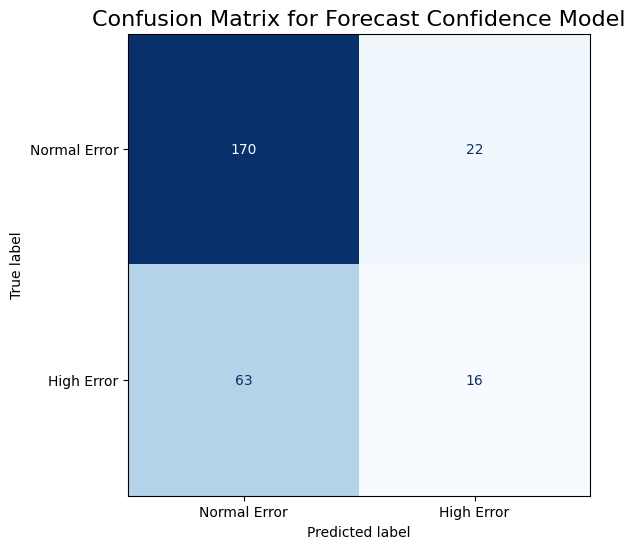


2. Generating Feature Importance Plot...
✅ Saved 'confidence_feature_importance.png'


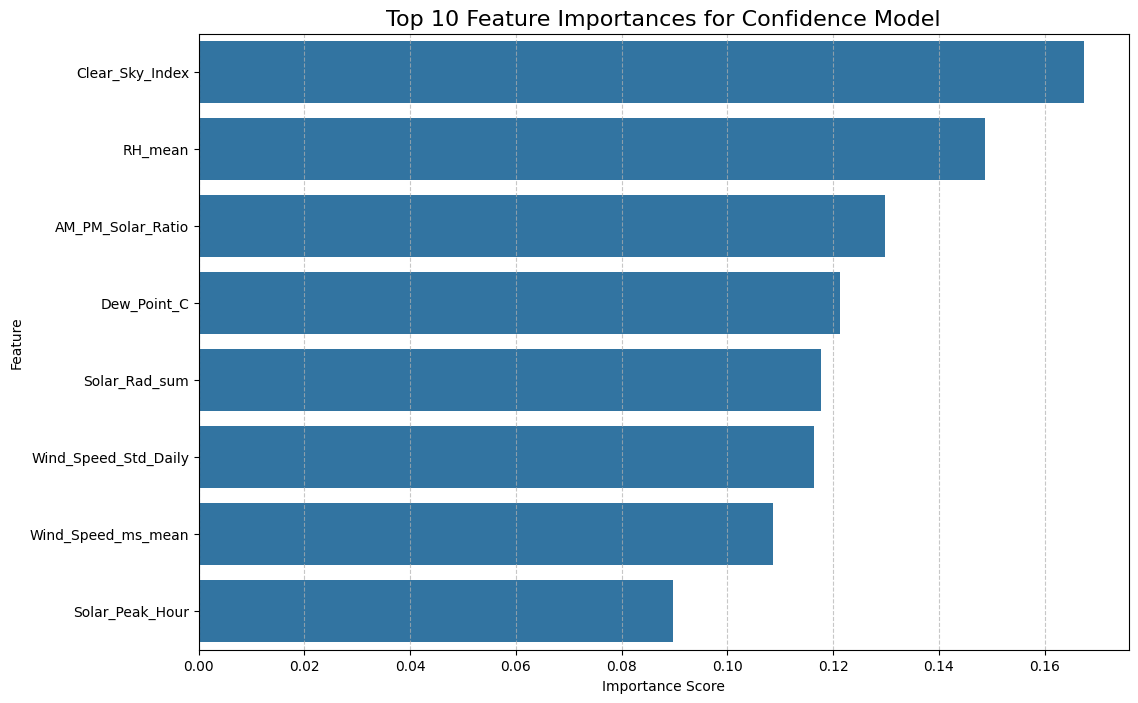


3. Generating Precision-Recall Curve...
✅ Saved 'confidence_precision_recall_curve.png'


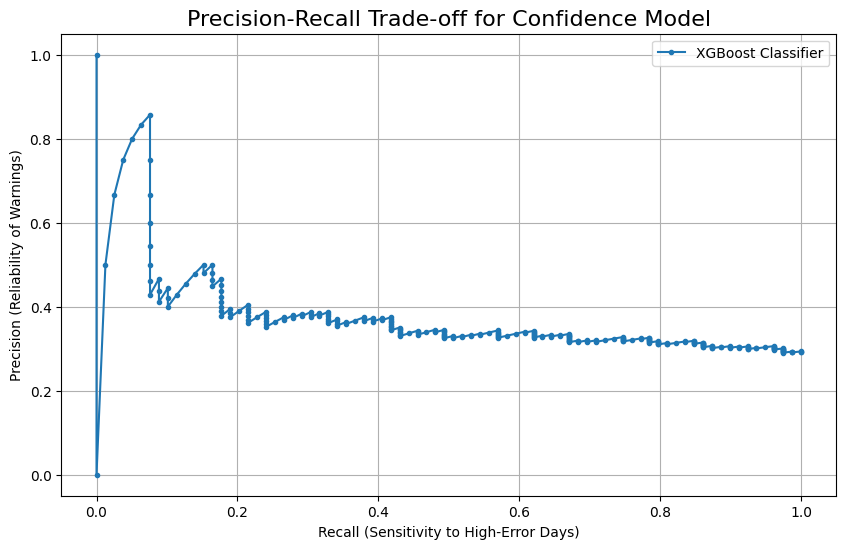

In [27]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

print("--- Generating Visuals for the Confidence Model ---")

# --- Visualization 1: The Confusion Matrix ---
print("\n1. Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal Error', 'High Error'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix for Forecast Confidence Model', fontsize=16)
plt.savefig('..\images\confidence_confusion_matrix.png', bbox_inches='tight')
print("✅ Saved 'confidence_confusion_matrix.png'")
plt.show()


# --- Visualization 2: Feature Importance ---
print("\n2. Generating Feature Importance Plot...")
importances = xgb_classifier.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10)) # Top 10 features
plt.title('Top 10 Feature Importances for Confidence Model', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('..\images\confidence_feature_importance.png', bbox_inches='tight')
print("✅ Saved 'confidence_feature_importance.png'")
plt.show()


# --- Visualization 3: Precision-Recall Curve ---
print("\n3. Generating Precision-Recall Curve...")
y_probs = xgb_classifier.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='XGBoost Classifier')
plt.xlabel('Recall (Sensitivity to High-Error Days)')
plt.ylabel('Precision (Reliability of Warnings)')
plt.title('Precision-Recall Trade-off for Confidence Model', fontsize=16)
plt.grid(True)
plt.legend()
plt.savefig('..\images\confidence_precision_recall_curve.png', bbox_inches='tight')
print("✅ Saved 'confidence_precision_recall_curve.png'")
plt.show()
